<a href="https://colab.research.google.com/github/tabaraei/aspect-based-sentiment-analysis/blob/main/ABSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Born and explanations provided to understand why the opinion is positive or negative, and at the end compare it with pre-trained model.

[Born Classifier](https://bornrule.eguidotti.com) is a text classification algorithm inspired by the notion of superposition of states in quantum
physics. Born provides good classification performance, explainability, and computational efficiency. In this
project, the goal is to exploit the Born explanation in order to use it for Aspect Based Sentiment Analysis. In
particular, the main idea to to proceed as follows:
1. Perform a sentiment analysis classification of documents using Born ✅
2. Extract the explanation features for each pair of documents and predicted labels ✅
3. Analyze the explanatory features in order to group them in candidate aspects ✅
- 3.1. Find the best threshold for aspects ✅
- 3.2. Evaluate the aspects with the best threshold ✅
4. Associate each aspect to a specific sentence or portion of the text
- 4.1. Find TP aspects
- 4.2. Find their associate sentiment using index of `Aspects` in` Aspect_Sentiments`
- 4.3. Get the sentence of each candidate aspect, and predict their sentiment
- 4.4. Evaluate
5. Predict the sentiment for the sentence or text portion using the trained Born classifier
6. Associate then a (potentially different) sentiment to each sentence or text portion according to the aspect
7. Finally, evaluate the quality of the results for each aspect.



TODO:
- add EDA visualizations
- add explanations
- finalize the sections of notebook
- ToC



## Libraries and Modules

In this section, we download and import a variety of libraries and packages necessary for various tasks related to natural language processing (NLP), sentiment analysis, data manipulation, and visualization. In addition, we mount Google Drive to the Colab environment to save and access datasets or model outputs.

In [49]:
%%capture
!python -m spacy download en_core_web_lg
!pip install datasets, bornrule, wordcloud

from google.colab import drive
from datasets import load_dataset
import kagglehub
import os
import warnings
import joblib
import re
import string

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

import spacy
from bornrule import BornClassifier
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax


drive.mount('/content/drive')
tqdm.pandas()
warnings.filterwarnings('ignore')
SAVE_DRIVE_PATH = '/content/drive/MyDrive/Data/ABSA'

nlp = spacy.load('en_core_web_lg')
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt_tab')

The Visualization class is designed to help visualize the results of aspect-based sentiment analysis (ABSA) by providing reusable visualization functions to be used throughout the notebook. This class includes the following functions:

1. `confusion_matrix`: This function takes in the confusion matrix, predicted labels, and true labels. It then generates a heatmap to visualize the performance of the sentiment classification model.

2. `aspect_detection_evaluation`: This function creates a line plot to visualize how evaluation metrics (e.g., accuracy, F1-score) change with respect to different thresholds used for aspect detection in ABSA. It also highlights the best aspect threshold using a vertical line.

3. `sentiment_distribution`: This function generates a count plot to show the distribution of different sentiment labels (e.g., positive, neutral, negative) within the dataset.

4. `word_cloud`: This function creates word clouds for positive, negative, and neutral global features extracted from `BornClassifier`, with words sized according to their probability, visualizing the most common words associated with each sentiment label in the dataset.

In [116]:
class Visualization:
    def confusion_matrix(self, cm, pred_labels, true_labels):
        plt.figure(figsize=(8, 4))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=pred_labels, yticklabels=true_labels)
        ax.set(xlabel='Predicted Labels', ylabel='True Labels', title='Confusion Matrix')

    def aspect_detection_evaluation(self, df, best_aspect_threshold):
        plt.figure(figsize=(8, 4))
        ax = sns.lineplot(data=df, x='Threshold', y='Value', hue='Metric', marker='', palette='Set2')
        ax.set_ylim(0, 1)
        ax.set(xlabel='Threshold', ylabel='Metric Value', title='Evaluation Metrics vs Thresholds')
        plt.axvline(x=best_aspect_threshold, color='grey', linestyle='--')

    def sentiment_distribution(self, df, class_labels):
        plt.figure(figsize=(8, 4))
        ax = sns.countplot(data=df, x='Sentiment', order=class_labels, palette=sns.color_palette(['#E99675', '#F2D27D', '#73B6A1']))
        ax.set(xlabel='Sentiment', ylabel='Count', title='Sentiment Distribution')

    def word_cloud(self, neg, neu, pos, class_labels, max_words=100, background_color='white', colormap='Set3'):
        wordcloud_neg = WordCloud(background_color=background_color, colormap=colormap).generate_from_frequencies(neg)
        wordcloud_neu = WordCloud(background_color=background_color, colormap=colormap).generate_from_frequencies(neu)
        wordcloud_pos = WordCloud(background_color=background_color, colormap=colormap).generate_from_frequencies(pos)

        fig, axes = plt.subplots(1, 3, figsize=(15, 8))
        for ax, title, wordcloud in zip(axes, class_labels, [wordcloud_neg, wordcloud_neu, wordcloud_pos]):
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(title)
            ax.axis('off')


visualize = Visualization()

## Datasets

While there are various datasets supporting [ABSA](https://paperswithcode.com/datasets?task=aspect-based-sentiment-analysis&page=1), the experiments throughout this notebook were conducted on the following datasets:

1. `AmazonReviewsDataset`: This dataset can be accessed on [Kaggle](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews), and it was only employed for experimenting sentiment classification and is not specifically suited for aspect-based sentiment analysis. It contains reviews of fine foods from Amazon, covering over 10 years and including approximately 500,000 reviews up to October 2012. Each review features product and user details, ratings, and the plain text review itself. Additionally, it includes reviews from various other Amazon categories.

2. `SemEval2014Dataset`: This dataset is a benchmark for aspect-based sentiment analysis tasks, and is accessible on [HuggingFace](https://huggingface.co/datasets/alexcadillon/SemEval2014Task4). While this repository provides two dataset categories, “restaurants” and “laptops” (both following the same format), our experiments were conducted solely on the “restaurants” dataset. This dataset contains a total of 7,886 rows, with each entry consisting of a given text, a list of aspect terms, and the corresponding sentiment associated with each of those aspects.

### Amazon Reviews Dataset

The intuition behind selecting this dataset was that, since the `BornClassifier` is a statistical model, it could benefit from being trained on a larger corpus. Training on this dataset was expected to expose the model to a broader vocabulary, with the `SemEval2014` dataset serving as the test set. However, this assumption did not hold true, as the model’s test performance in sentiment classification was unsatisfactory, a topic that will be addressed in a later chapter.

As this dataset only contains user-provided scores for each review, and our focus is on the overall sentiment, the ratings were converted into sentiment categories: scores of 4 and 5 were mapped to positive, 3 to neutral, and 1 and 2 to negative. For this task, we retained only the documents along with their corresponding sentiment labels.

In [25]:
class AmazonReviewsDataset:
    def __init__(self):
        self.KAGGLE_DATASET_PATH = 'snap/amazon-fine-food-reviews'
        self.create_dataset()
        self.class_labels = sorted(self.dataset['Sentiment'].unique())

    def map_score_to_sentiment(self, score):
        if score < 3: return 'negative'
        elif score == 3: return 'neutral'
        elif score > 3: return 'positive'

    def create_dataset(self):
        kaggle_path = kagglehub.dataset_download(self.KAGGLE_DATASET_PATH)
        path = os.path.join(kaggle_path, 'Reviews.csv')

        self.dataset = pd.read_csv(path)
        self.dataset['Sentiment'] = self.dataset['Score'].apply(self.map_score_to_sentiment)
        self.dataset = self.dataset.rename(columns={'Text': 'Document'})[['Document', 'Sentiment']]

        self.train_df, self.test_df = \
            train_test_split(self.dataset, test_size=0.2, random_state=42, stratify=self.dataset['Sentiment'])
        self.train_df = self.train_df.reset_index(drop=True)
        self.test_df = self.test_df.reset_index(drop=True)

In [26]:
amazon = AmazonReviewsDataset()
amazon.dataset.head()

,Document,Sentiment
0,I have bought several of the Vitality canned d...,positive
1,Product arrived labeled as Jumbo Salted Peanut...,negative
2,This is a confection that has been around a fe...,positive
3,If you are looking for the secret ingredient i...,negative
4,Great taffy at a great price. There was a wid...,positive


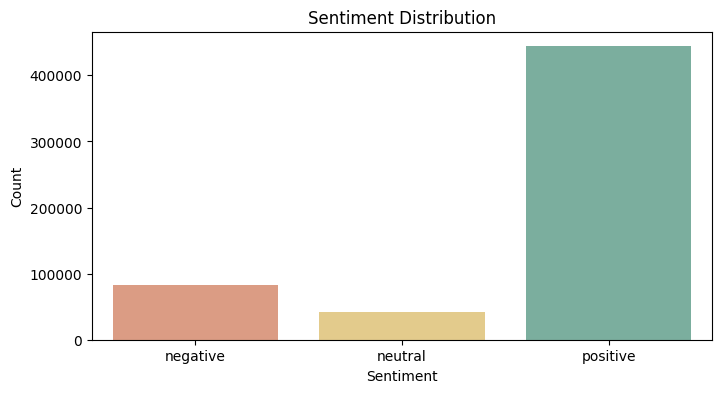

In [71]:
visualize.sentiment_distribution(amazon.dataset, amazon.class_labels)

### SemEval2014 Dataset

This dataset is primarily used for aspect-based sentiment analysis. However, since it does not include overall sentiment labels for each document, which are required for the initial phase of the project involving sentiment classification using the `BornClassifier`, these labels were estimated based on the sentiments assigned to the aspects within each document. The labeling approach is as follows:

- `positive`, if the number of positive aspects exceeds the number of negative aspects.
- `negative`, if the number of negative aspects exceeds the number of positive aspects.
- `neutral`, otherwise.

In [27]:
class SemEval2014Dataset:
    def __init__(self, task='restaurants'):
        self.HUGGING_FACE_DATASET_PATH = 'alexcadillon/SemEval2014Task4'
        self.task = task
        self.create_dataset()
        self.class_labels = sorted(self.dataset['Sentiment'].unique())

    def compute_overall_sentiment(self, aspect_sentiments):
        pos_count = aspect_sentiments.count('positive')
        neg_count = aspect_sentiments.count('negative')

        if pos_count > neg_count:
            return 'positive'
        elif neg_count > pos_count:
            return 'negative'
        else:
            return 'neutral'

    def transform_dataset(self, df):
        data = []
        for entry in df:
            document = entry['text']
            aspects = [aspect['term'] for aspect in entry['aspectTerms']]
            aspect_sentiments = [aspect['polarity'] for aspect in entry['aspectTerms']]
            overall_sentiment = self.compute_overall_sentiment(aspect_sentiments)
            data.append({
                'Document': document,
                'Aspects': aspects,
                'Aspect_Sentiments': aspect_sentiments,
                'Sentiment': overall_sentiment
            })
        return pd.DataFrame(data)

    def create_dataset(self):
        dataset = load_dataset(self.HUGGING_FACE_DATASET_PATH, self.task)
        self.train_df = self.transform_dataset(dataset['train'])
        self.test_df = self.transform_dataset(dataset['test'])
        self.dataset = pd.concat([self.train_df, self.test_df], ignore_index=True)

In [28]:
semeval = SemEval2014Dataset(task='restaurants')
semeval.dataset.head()

,Document,Aspects,Aspect_Sentiments,Sentiment
0,But the staff was so horrible to us.,[staff],[negative],negative
1,"To be completely fair, the only redeeming fact...",[food],[positive],positive
2,"The food is uniformly exceptional, with a very...","[food, kitchen, menu]","[positive, positive, neutral]",positive
3,Where Gabriela personaly greets you and recomm...,[],[],neutral
4,"For those that go once and don't enjoy it, all...",[],[],neutral


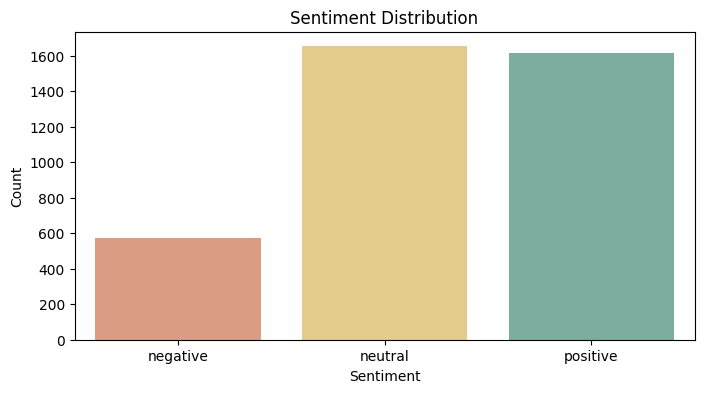

In [72]:
visualize.sentiment_distribution(semeval.dataset, semeval.class_labels)

## Sentiment Analysis using Born

In [29]:
class SentimentAnalysis:
    def __init__(self, train_df, test_df, class_labels):
        self.train_df = train_df
        self.test_df = test_df
        self.class_labels = class_labels
        self.vectorize_documents()

    def vectorize_documents(self):
        self.vec = CountVectorizer(tokenizer=word_tokenize, lowercase=True, token_pattern=None)
        self.X_train = self.vec.fit_transform(self.train_df['Document'])
        self.X_test = self.vec.transform(self.test_df['Document'])
        self.y_train = self.train_df['Sentiment']
        self.y_test = self.test_df['Sentiment']
        self.features = self.vec.get_feature_names_out()
        print(f'Number of features: {len(self.features)}\n')

    def train_and_test(self):
        self.clf = BornClassifier()
        self.clf.fit(self.X_train, self.y_train)
        self.global_explain = pd.DataFrame(self.clf.explain().toarray(), index=self.features, columns=self.class_labels)

        self.y_pred = self.clf.predict(self.X_test)
        print(classification_report(self.y_test, self.y_pred))

    def visualize_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred, labels=self.class_labels)
        visualize.confusion_matrix(cm, pred_labels=self.class_labels, true_labels=self.class_labels)

    def analyze_prediction_for_document(self, document_id, train_or_test='test'):
        if train_or_test == 'train':
            df = self.train_df
            X = self.X_train
        elif train_or_test == 'test':
            df = self.test_df
            X = self.X_test

        document = df.loc[document_id, 'Document']
        sentiment = df.loc[document_id, 'Sentiment']
        vectorized_doc = X[document_id]
        prediction = self.clf.predict(vectorized_doc)[0]
        print(f'Document: {document}\nTrue Sentiment: {sentiment}\nPrediction: {prediction}\n')
        return pd.DataFrame(self.clf.predict_proba(vectorized_doc), columns=self.class_labels, index=['probability'])

    def get_global_explain(self):
        positive = self.global_explain['positive'].sort_values(ascending=False)
        neutral = self.global_explain['neutral'].sort_values(ascending=False)
        negative = self.global_explain['negative'].sort_values(ascending=False)
        return negative, neutral, positive

### Train and Test on `AmazonReviewsDataset`



              precision    recall  f1-score   support

    negative       0.61      0.71      0.65     16407
     neutral       0.29      0.46      0.36      8528
    positive       0.94      0.86      0.90     88756

    accuracy                           0.81    113691
   macro avg       0.61      0.67      0.64    113691
weighted avg       0.84      0.81      0.82    113691



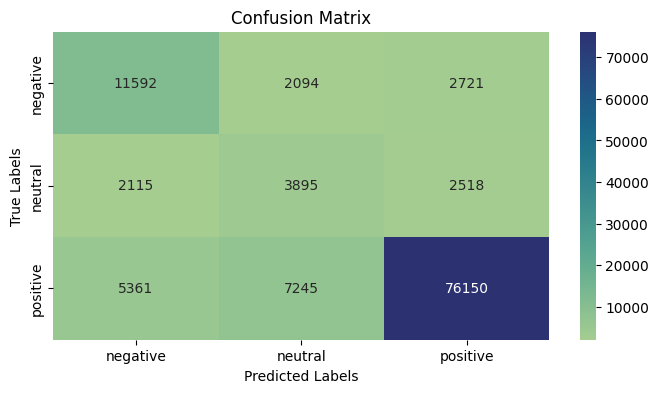

In [30]:
load_dataset = True

if load_dataset:
    amazon_sentiment_analysis = joblib.load(f'{SAVE_DRIVE_PATH}/amazon_sentiment_analysis.pkl')
else:
    amazon_sentiment_analysis = SentimentAnalysis(
        train_df=amazon.train_df,
        test_df=amazon.test_df,
        class_labels=amazon.class_labels
    )
    joblib.dump(amazon_sentiment_analysis, f'{SAVE_DRIVE_PATH}/amazon_sentiment_analysis.pkl')

amazon_sentiment_analysis.train_and_test()
amazon_sentiment_analysis.visualize_confusion_matrix()

In [31]:
amazon_sentiment_analysis.analyze_prediction_for_document(document_id=0, train_or_test='test')

Document: I do enjoy most of the Popchip flavours.  This one has a nice balance and I don't get tired too quickly of this flavor.  Better than the jalape&ntilde;o flavor, but I still prefer the multi-pack.
True Sentiment: positive
Prediction: neutral



,negative,neutral,positive
probability,0.25085,0.39631,0.352841


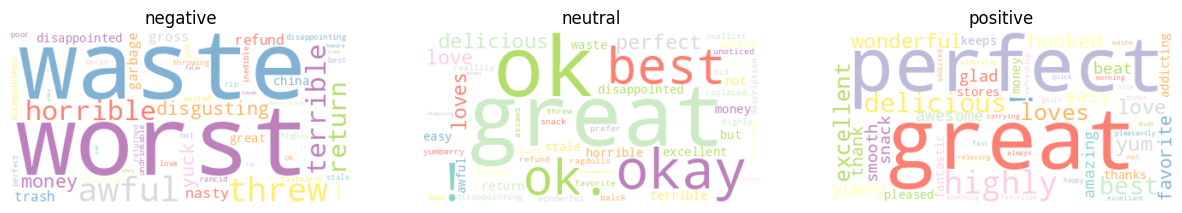

In [117]:
negative, neutral, positive = amazon_sentiment_analysis.get_global_explain()

visualize.word_cloud(
    pos=positive.head(50).to_dict(),
    neu=neutral.head(50).to_dict(),
    neg=negative.head(50).to_dict(),
    class_labels=amazon.class_labels
)

### Train and Test on `SemEval2014Dataset`

              precision    recall  f1-score   support

    negative       0.51      0.58      0.55       125
     neutral       0.72      0.57      0.63       279
    positive       0.74      0.82      0.78       396

    accuracy                           0.70       800
   macro avg       0.66      0.66      0.65       800
weighted avg       0.70      0.70      0.69       800



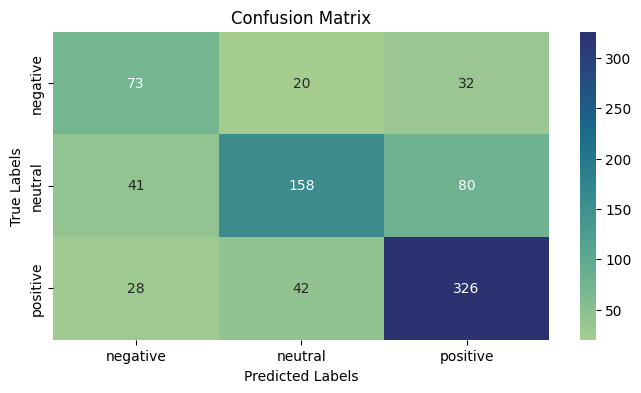

In [33]:
load_dataset = True

if load_dataset:
    semeval_sentiment_analysis = joblib.load(f'{SAVE_DRIVE_PATH}/semeval_sentiment_analysis.pkl')
else:
    semeval_sentiment_analysis = SentimentAnalysis(
        train_df=semeval.train_df,
        test_df=semeval.test_df,
        class_labels=semeval.class_labels
    )
    joblib.dump(semeval_sentiment_analysis, f'{SAVE_DRIVE_PATH}/semeval_sentiment_analysis.pkl')

semeval_sentiment_analysis.train_and_test()
semeval_sentiment_analysis.visualize_confusion_matrix()

In [34]:
semeval_sentiment_analysis.analyze_prediction_for_document(document_id=0, train_or_test='test')

Document: The bread is top notch as well.
True Sentiment: positive
Prediction: positive



,negative,neutral,positive
probability,0.146435,0.174319,0.679246


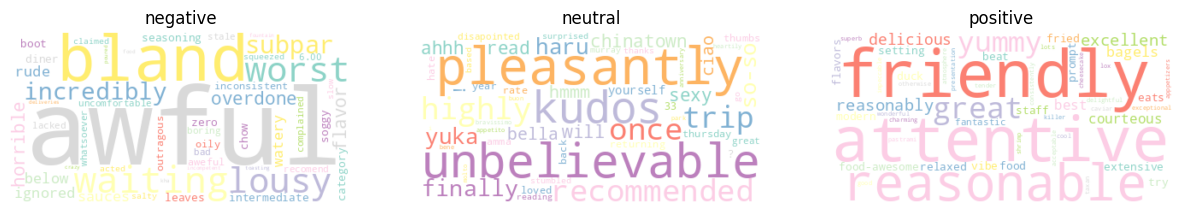

In [118]:
negative, neutral, positive = semeval_sentiment_analysis.get_global_explain()

visualize.word_cloud(
    pos=positive.head(50).to_dict(),
    neu=neutral.head(50).to_dict(),
    neg=negative.head(50).to_dict(),
    class_labels=semeval.class_labels
)

### Train on `AmazonReviewsDataset`, Test on `SemEval2014Dataset`

              precision    recall  f1-score   support

    negative       0.32      0.51      0.39       575
     neutral       0.47      0.16      0.24      1653
    positive       0.55      0.80      0.65      1613

    accuracy                           0.48      3841
   macro avg       0.45      0.49      0.43      3841
weighted avg       0.48      0.48      0.44      3841



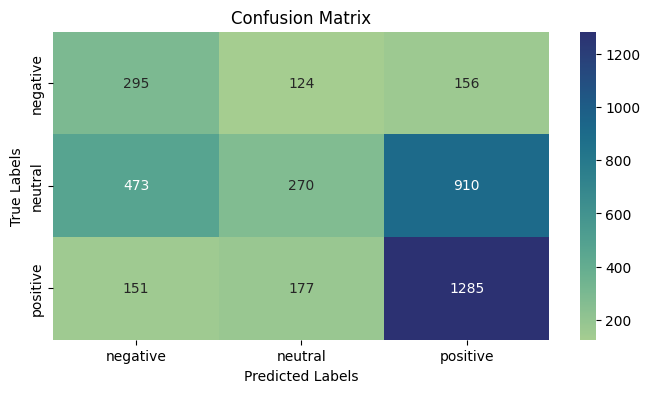

In [36]:
load_dataset = True

if load_dataset:
    joint_sentiment_analysis = joblib.load(f'{SAVE_DRIVE_PATH}/joint_sentiment_analysis.pkl')
else:
    joint_sentiment_analysis = SentimentAnalysis(
        train_df=amazon.dataset,
        test_df=semeval.dataset,
        class_labels=amazon.class_labels
    )
    joblib.dump(joint_sentiment_analysis, f'{SAVE_DRIVE_PATH}/joint_sentiment_analysis.pkl')

joint_sentiment_analysis.train_and_test()
joint_sentiment_analysis.visualize_confusion_matrix()

In [37]:
joint_sentiment_analysis.analyze_prediction_for_document(document_id=0, train_or_test='test')

Document: But the staff was so horrible to us.
True Sentiment: negative
Prediction: negative



,negative,neutral,positive
probability,0.58473,0.271331,0.143939


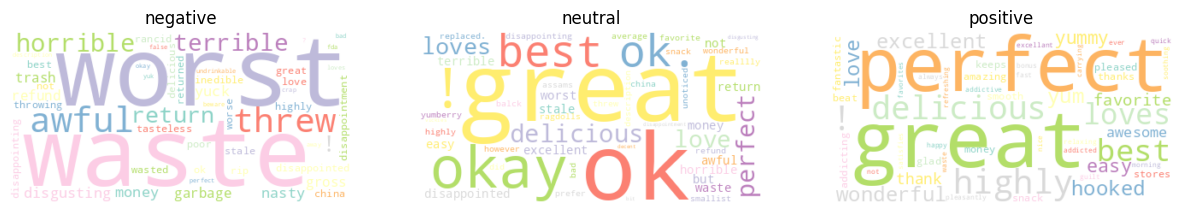

In [119]:
negative, neutral, positive = joint_sentiment_analysis.get_global_explain()

visualize.word_cloud(
    pos=positive.head(50).to_dict(),
    neu=neutral.head(50).to_dict(),
    neg=negative.head(50).to_dict(),
    class_labels=semeval.class_labels
)

## Aspect Detection

In [39]:
class AspectDetection:
    def __init__(self, sentiment_analysis):
        self.clf = sentiment_analysis.clf
        self.vec = sentiment_analysis.vec
        self.features = sentiment_analysis.features
        self.class_labels = sentiment_analysis.class_labels
        self.train_df = sentiment_analysis.train_df
        self.test_df = sentiment_analysis.test_df
        self.X_train = sentiment_analysis.X_train
        self.X_test = sentiment_analysis.X_test

        self.train_df['TOKENS'], self.train_df['NOUNS'] = zip(*self.train_df['Document'].apply(self.detect_nouns).tolist())
        self.test_df['TOKENS'], self.test_df['NOUNS'] = zip(*self.test_df['Document'].apply(self.detect_nouns).tolist())

        self.train_df['PREDICTION'] = self.clf.predict(self.X_train)
        self.test_df['PREDICTION'] = self.clf.predict(self.X_test)

    def detect_nouns(self, document):
        doc = nlp(document)
        tokens = [token.text.lower() for token in doc]
        nouns = [token.text.lower() for token in doc if token.pos_ in ['NOUN', 'PROPN']]
        return tokens, nouns

    def shorten_aspect_tokens(self, set1, set2):
        '''
        This function aims to match the tokens in set1 with the tokens in set2 in cases
        that the string in one set is substring in another. For example, when dealing
        with evaluation of aspects such as "battery life", it could be seen equivalent
        to "battery" or "battery life expectancy" for a more accurate evaluation.
        '''
        set1_reduced = set()
        for t in set1:
            match_found = False
            for c in set2:
                if t in c:
                    set1_reduced.add(t)
                    match_found = True
                    break
                elif c in t:
                    set1_reduced.add(c)
                    match_found = True
                    break
            if not match_found:
                set1_reduced.add(t)
        return set1_reduced

    def get_candidate_aspects(self, vectorized_doc, PREDICTION, NOUNS, aspect_threshold=0):
        '''
        For a given vectorized document, first we compute its overall sentiment, based
        on which we retrieve the corresponding explanatory features. Then, we keep the
        non-zero features (controlled by threshold), filtering only nouns as aspects
        '''
        local_explain = pd.DataFrame(self.clf.explain(vectorized_doc).toarray(), index=self.features, columns=self.class_labels)
        candidates = local_explain[PREDICTION][local_explain[PREDICTION] > aspect_threshold]
        return [candidate for candidate in candidates.index if candidate in NOUNS]

    def evaluate_aspect_detection(self, aspect_threshold=0, train_or_test='train'):
        '''
        True Positive (TP): Elements in both candidate_set and true_set.
        False Positive (FP): Elements in candidate_set but not in true_set.
        False Negative (FN): Elements in true_set but not in candidate_set.
        True Negative (TN): Rewarded when both sets are empty
        '''
        TP, FP, TN, FN = 0, 0, 0, 0

        if train_or_test == 'train':
            df = self.train_df
            X = self.X_train
        elif train_or_test == 'test':
            df = self.test_df
            X = self.X_test

        all_tokens = df['TOKENS'].tolist()
        true_aspects = [[aspect.lower() for aspect in aspects] for aspects in df['Aspects'].tolist()]
        candidate_aspects = df.apply(lambda d: self.get_candidate_aspects(
                vectorized_doc=X[d.name],
                PREDICTION=d.PREDICTION,
                NOUNS=d.NOUNS,
                aspect_threshold=aspect_threshold
            ),
            axis=1
        ).tolist()

        for candidate_aspect, true_aspect, tokens in zip(candidate_aspects, true_aspects, all_tokens):
            candidate_aspect = self.shorten_aspect_tokens(set(candidate_aspect), set(true_aspect))
            true_aspect = self.shorten_aspect_tokens(set(true_aspect), set(candidate_aspect))

            TP += len(candidate_aspect & true_aspect)
            FP += len(candidate_aspect - true_aspect)
            FN += len(true_aspect - candidate_aspect)
            TN += len(set(tokens) - candidate_aspect - true_aspect)

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        evaluation_metrics = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

        cm = pd.DataFrame(np.array([[TP, FN],[FP, TN]]),
            index=['Aspect', 'Non-Aspect'],
            columns=['Aspect', 'Non-Aspect'])

        return evaluation_metrics, cm

    def get_sentence_for_aspects(self, document, aspects, aspect_sentiments):
        '''
        For a given document (which might contain multiple sentences), it splits
        the doc into sentences, transform them using the same transformation on
        aspects, and returns the first-matching sentence for each aspect.
        '''
        clean_sides = string.punctuation + string.whitespace
        sentences = re.split(r'(?<=[:;.!?()])', document)
        sentences = [sentence.strip(clean_sides) for sentence in sentences if sentence.strip(clean_sides)]

        return pd.DataFrame([
            {'Aspect': aspect, 'Sentence': sentence, 'Aspect_Sentiment': aspect_sentiment}
            for aspect, aspect_sentiment in zip(aspects, aspect_sentiments)
            for sentence in [next((s for s in sentences if aspect.lower() in s.lower()), None)]
            if sentence is not None
        ])

    def get_df_aspect_sentence_sentiment(self):
        df = pd.concat([self.train_df, self.test_df], ignore_index=True)
        df = pd.concat(
            df.apply(
                lambda d: self.get_sentence_for_aspects(d.Document, d.Aspects, d.Aspect_Sentiments),
                axis=1
            ).tolist(),
            ignore_index=True
        )
        df = df[df['Aspect_Sentiment'] != 'conflict']
        return df

    def evaluate_aspect_sentiments_in_portions(self):
        '''
        In the whole dataset, detect the corresponding sentence portion for each
        aspect, and compare the true aspect sentiment with the predicted sentiment
        for the portion.
        '''
        df = self.get_df_aspect_sentence_sentiment()
        df['Predicted_Aspect_Sentiment'] = self.clf.predict(self.vec.transform(df['Sentence']))

        print(classification_report(df['Aspect_Sentiment'], df['Predicted_Aspect_Sentiment']))
        cm = confusion_matrix(df['Aspect_Sentiment'], df['Predicted_Aspect_Sentiment'], labels=self.class_labels)
        return cm


AD = AspectDetection(semeval_sentiment_analysis)

### Optimizing Aspect Detection Threshold

It took `06:25:11` to run, giving `Best F1-Score: 0.568` with `Corresponding Aspect Threshold: 0.000395`

In [40]:
load_evaluations = True

if load_evaluations:
    evaluations_df = joblib.load(f'{SAVE_DRIVE_PATH}/evaluations.pkl')
else:
    evaluations_list = list()
    aspect_thresholds = tqdm(np.linspace(0.0001, 0.002, 1200))

    for aspect_threshold in aspect_thresholds:
        evaluation_metrics, _ = AD.evaluate_aspect_detection(aspect_threshold, train_or_test='train')
        evaluations_list.append(evaluation_metrics)
        aspect_thresholds.set_description(f'Threshold: {aspect_threshold:.6f}       ' +
                                        f'Accuracy: {evaluation_metrics["accuracy"]:.2f}, ' +
                                        f'Precision: {evaluation_metrics["precision"]:.2f}, ' +
                                        f'Recall: {evaluation_metrics["recall"]:.2f}, ' +
                                        f'F-1: {evaluation_metrics["f1"]:.2f}')

    evaluations_df = pd.DataFrame(evaluations_list, index=aspect_thresholds)
    joblib.dump(evaluations_df, f'{SAVE_DRIVE_PATH}/evaluations.pkl')


best_aspect_threshold = evaluations_df['f1'].idxmax()
best_f1_score = evaluations_df.loc[best_aspect_threshold, 'f1']

print(f'Best F1-Score: {best_f1_score:.3f}')
print(f'Corresponding Aspect Threshold: {best_aspect_threshold:.6f}\n')

Best F1-Score: 0.568
Corresponding Aspect Threshold: 0.000395



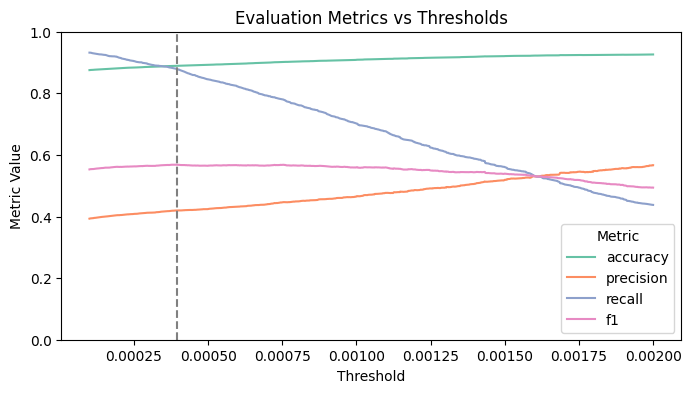

In [54]:
df = evaluations_df.reset_index(names='Threshold').melt(id_vars='Threshold', var_name='Metric', value_name='Value')
visualize.aspect_detection_evaluation(df, best_aspect_threshold)

### Sample Aspect Detection and Token Shortener

In [42]:
document_id = 15
vectorized_doc = AD.X_train[document_id]

row = AD.train_df.iloc[document_id]
document = row.Document
PREDICTION = row.PREDICTION
NOUNS = row.NOUNS

true_aspects = row.Aspects
candidate_aspects = AD.get_candidate_aspects(vectorized_doc, PREDICTION, NOUNS, aspect_threshold=best_aspect_threshold)

print(f'Document: {document}\nTrue Aspects: {true_aspects}\nDetected Aspects: {candidate_aspects}')

Document: The pizza is the best if you like thin crusted pizza.
True Aspects: ['pizza', 'thin crusted pizza']
Detected Aspects: ['pizza']


In [43]:
true_aspects_shortened = AD.shorten_aspect_tokens(true_aspects, candidate_aspects)
candidate_aspects_shortened = AD.shorten_aspect_tokens(candidate_aspects, true_aspects)

print(f'Shortened True Aspects: {true_aspects_shortened}')
print(f'Shortened Candidate Aspects: {candidate_aspects_shortened}')

Shortened True Aspects: {'pizza'}
Shortened Candidate Aspects: {'pizza'}


### Aspect Detection Evaluation on Test Data

In [44]:
evaluation_metrics, cm = AD.evaluate_aspect_detection(best_aspect_threshold, train_or_test='test')
pd.DataFrame([evaluation_metrics], index=['value'])

,accuracy,precision,recall,f1
value,0.918509,0.548289,0.800893,0.650943


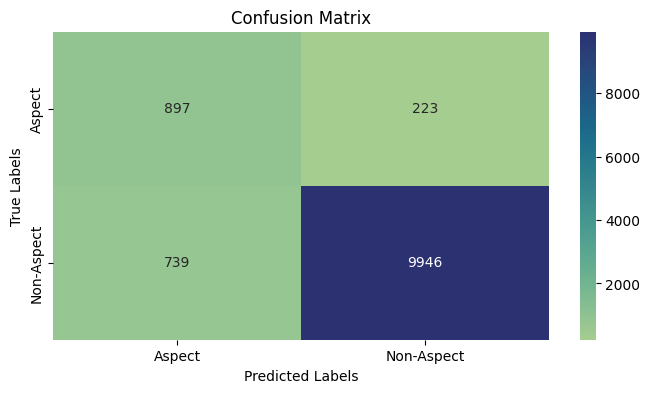

In [45]:
visualize.confusion_matrix(cm, pred_labels=cm.columns, true_labels=cm.index)

## Aspect-to-Sentence Association and Evaluation of Predicted Sentiments

- First utilized sent_tokenize from NLTK, but it was unable to detect text portions as it only detects complete sentences.
- Wanted to use a sophisticated detection of aspects in sentences based on vectorizing the tokens, but it didn't work well and there were inaccuracies due to out-of-vocabulary tokens.


```python
def find_aspect_in_sentences(self, aspect, transformed_aspect, sentences, transformed_sentences, aspect_sentiment):
    '''
    First, it finds the index of the aspect in the whole vocabulary, which might
    have been transformed in any way (bigram, lemma, lowercase). Then, it finds
    the first-matching sentence in the list of given sentences and returns it.
    In the cases where the token is not in vocabulary, it directly looks for the
    aspect in the sentence.
    '''
    aspect_token_indices = set(transformed_aspect.nonzero()[1])

    for sentence, transformed_sentence in zip(sentences, transformed_sentences):
        sentence_token_indices = transformed_sentence.nonzero()[1]
        result = pd.Series({'Aspect': aspect, 'Sentence': sentence, 'Aspect_Sentiment': aspect_sentiment})

        if not aspect_token_indices:
            if aspect.lower() in sentence.lower():
                return result
        elif aspect_token_indices.issubset(sentence_token_indices):
            return result
```

### Sample Portion Detection for Aspects

In [46]:
document_id = 453

row = AD.test_df.iloc[document_id]
document = row.Document
true_aspects = row.Aspects
aspect_sentiments = row.Aspect_Sentiments

print(f'Document: {document}\nTrue Aspects: {true_aspects}\nAspect Sentiments: {aspect_sentiments}')

Document: You must try Odessa stew or Rabbit stew; salads-all good; and kompot is soo refreshing during the hot summer day (they make it the way my mom does, reminds me of home a lot).
True Aspects: ['Odessa stew', 'Rabbit stew', 'salads', 'kompot']
Aspect Sentiments: ['positive', 'positive', 'positive', 'positive']


In [47]:
AD.get_sentence_for_aspects(document, true_aspects, aspect_sentiments)

,Aspect,Sentence,Aspect_Sentiment
0,Odessa stew,You must try Odessa stew or Rabbit stew,positive
1,Rabbit stew,You must try Odessa stew or Rabbit stew,positive
2,salads,salads-all good,positive
3,kompot,and kompot is soo refreshing during the hot su...,positive


### Evaluation of Aspect Sentiments in Portions

              precision    recall  f1-score   support

    negative       0.68      0.80      0.73      1001
     neutral       0.55      0.31      0.40       828
    positive       0.85      0.91      0.88      2874

    accuracy                           0.78      4703
   macro avg       0.70      0.67      0.67      4703
weighted avg       0.76      0.78      0.76      4703



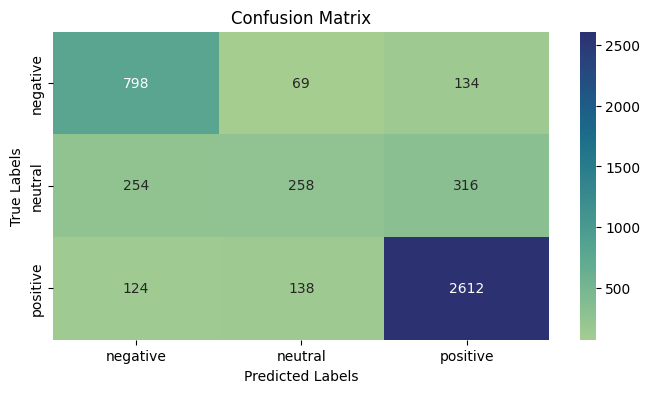

In [50]:
cm = AD.evaluate_aspect_sentiments_in_portions()
visualize.confusion_matrix(cm, pred_labels=AD.class_labels, true_labels=AD.class_labels)

## Experiments with LLMs

Comparison:

1. NLTK's `SentimentIntensityAnalyzer` model: This model assigns a sentiment intensity score to sentences, returning a float for sentiment strength based on the input text. [(link)](https://www.nltk.org/api/nltk.sentiment.SentimentIntensityAnalyzer.html)

2. HuggingFace's `RoBERTa` model: This roBERTa-base model has been trained on ~58M tweets and finetuned for sentiment analysis with the TweetEval benchmark. It returns a sentiment score for each of the negative, neutral, and positive cases. [(link)](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment)

In [ ]:
class NLTK:
    def __init__(self, dataset, class_labels):
        self.dataset = dataset
        self.class_labels = class_labels
        self.sentiment_analyzer = SentimentIntensityAnalyzer()

    def predict_sentiment(self, document):
        scores = self.sentiment_analyzer.polarity_scores(document)
        if scores['compound'] >= 0.05: return 'positive'
        elif scores['compound'] <= -0.05: return 'negative'
        else: return 'neutral'

    def evaluate_model(self, document_col_name, sentiment_col_name):
        predictions = self.dataset[document_col_name].progress_apply(self.predict_sentiment)
        print('\n', classification_report(self.dataset[sentiment_col_name], predictions))
        cm = confusion_matrix(self.dataset[sentiment_col_name], predictions, labels=self.class_labels)
        return cm

In [ ]:
class RoBERTa:
    def __init__(self, dataset, class_labels):
        self.dataset = dataset
        self.class_labels = class_labels
        self.HUGGING_FACE_MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"
        self.model = AutoModelForSequenceClassification.from_pretrained(self.HUGGING_FACE_MODEL_NAME)
        self.tokenizer = AutoTokenizer.from_pretrained(self.HUGGING_FACE_MODEL_NAME)

    def predict_sentiment(self, document):
        encoded_text = self.tokenizer(document, return_tensors='pt', padding=True)
        output = self.model(**encoded_text)
        logits = output.logits.detach().numpy()[0]
        scores = softmax(logits)

        labels = ['negative', 'neutral', 'positive']
        sentiment_scores = dict(zip(labels, scores))
        predicted_label = max(sentiment_scores, key=sentiment_scores.get)
        return predicted_label

    def evaluate_model(self, document_col_name, sentiment_col_name):
        predictions = self.dataset[document_col_name].progress_apply(self.predict_sentiment)
        print('\n', classification_report(self.dataset[sentiment_col_name], predictions))
        cm = confusion_matrix(self.dataset[sentiment_col_name], predictions, labels=self.class_labels)
        return cm

### Sentiment Classification

In [ ]:
dataset = semeval.dataset
class_labels = semeval.class_labels
document_col_name = 'Document'
sentiment_col_name = 'Sentiment'

100%|██████████| 3841/3841 [00:00<00:00, 5046.26it/s]



               precision    recall  f1-score   support

    negative       0.45      0.41      0.43       575
     neutral       0.59      0.36      0.45      1653
    positive       0.57      0.82      0.67      1613

    accuracy                           0.56      3841
   macro avg       0.54      0.53      0.52      3841
weighted avg       0.56      0.56      0.54      3841



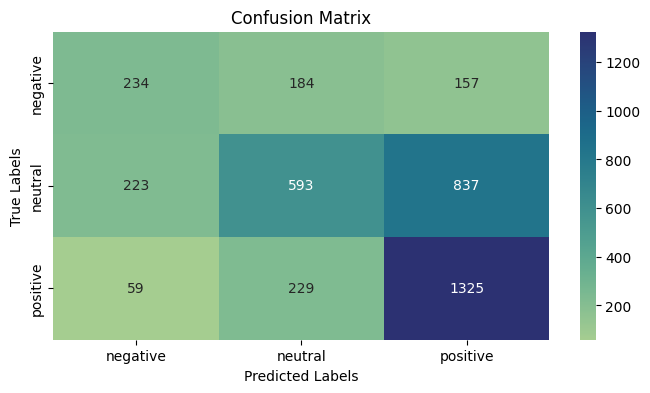

In [ ]:
nltk_semeval = NLTK(dataset, class_labels)
cm = nltk_semeval.evaluate_model(document_col_name, sentiment_col_name)
visualize.confusion_matrix(cm, pred_labels=class_labels, true_labels=class_labels)

100%|██████████| 3841/3841 [08:31<00:00,  7.52it/s]



               precision    recall  f1-score   support

    negative       0.51      0.67      0.58       575
     neutral       0.64      0.37      0.47      1653
    positive       0.65      0.85      0.74      1613

    accuracy                           0.62      3841
   macro avg       0.60      0.63      0.59      3841
weighted avg       0.62      0.62      0.60      3841



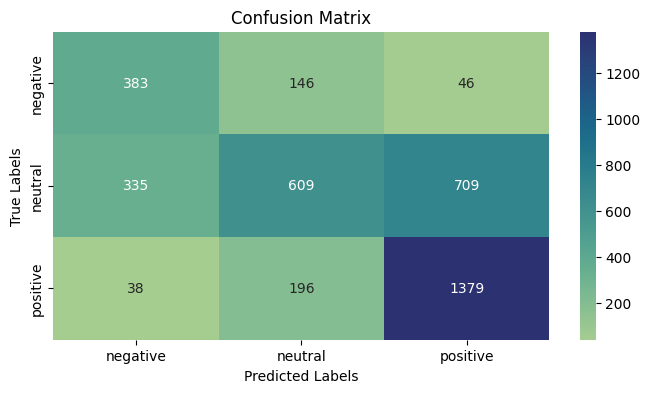

In [ ]:
roberta_semeval = RoBERTa(dataset, class_labels)
cm = roberta_semeval.evaluate_model(document_col_name, sentiment_col_name)
visualize.confusion_matrix(cm, pred_labels=class_labels, true_labels=class_labels)

### Aspect-Based Sentiment Classification

In [ ]:
dataset = AD.get_df_aspect_sentence_sentiment()
class_labels = sorted(dataset['Aspect_Sentiment'].unique())
document_col_name = 'Sentence'
sentiment_col_name = 'Aspect_Sentiment'

100%|██████████| 4703/4703 [00:01<00:00, 4663.77it/s]



               precision    recall  f1-score   support

    negative       0.65      0.39      0.49      1001
     neutral       0.33      0.45      0.38       828
    positive       0.78      0.80      0.79      2874

    accuracy                           0.65      4703
   macro avg       0.58      0.55      0.55      4703
weighted avg       0.67      0.65      0.65      4703



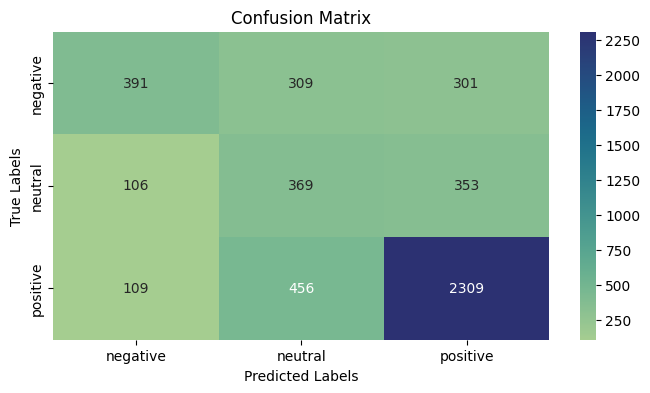

In [ ]:
nltk_aspect_sentence = NLTK(dataset, class_labels)
cm = nltk_aspect_sentence.evaluate_model(document_col_name, sentiment_col_name)
visualize.confusion_matrix(cm, pred_labels=class_labels, true_labels=class_labels)

100%|██████████| 4703/4703 [10:59<00:00,  7.13it/s]



               precision    recall  f1-score   support

    negative       0.72      0.63      0.67      1001
     neutral       0.38      0.52      0.44       828
    positive       0.87      0.82      0.84      2874

    accuracy                           0.73      4703
   macro avg       0.66      0.66      0.65      4703
weighted avg       0.75      0.73      0.74      4703



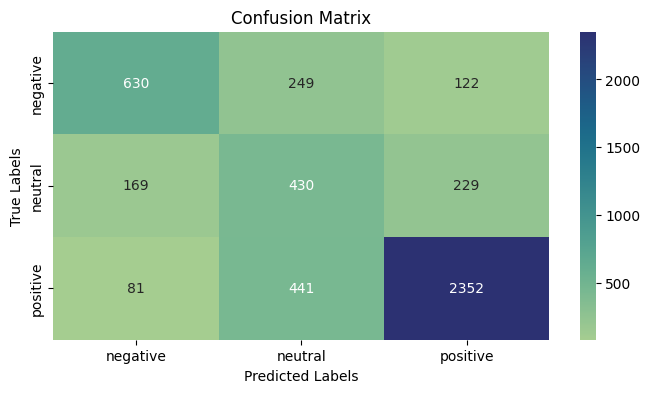

In [ ]:
roberta_aspect_sentence = RoBERTa(dataset, class_labels)
cm = roberta_aspect_sentence.evaluate_model(document_col_name, sentiment_col_name)
visualize.confusion_matrix(cm, pred_labels=class_labels, true_labels=class_labels)

## References

- Emanuele Guidotti and Alfio Ferrara. Text Classification with Born’s Rule. Advances in Neural Information
Processing Systems, 2022.
- Schouten, K., & Frasincar, F. (2015). Survey on aspect-level sentiment analysis. IEEE Transactions on
Knowledge and Data Engineering, 28(3), 813-830. [link](https://ieeexplore.ieee.org/document/7286808)
- Rana, T. A., & Cheah, Y. N. (2016). Aspect extraction in sentiment analysis: comparative analysis and survey.
Artificial Intelligence Review, 46(4), 459-483. [link](https://link.springer.com/article/10.1007/s10462-016-9472-z)